In [ ]:

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import scipy.io
import umap

import anndata
import scanpy as sc
import scvi
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph

/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarn

In [4]:
#adata = anndata.read_h5ad("../Data/dogma_all_genes_cells_75unpaired_processed.h5ad.gz")
adata = anndata.read_h5ad("../Data/dogma_all_genes_cells_2ineach_processed.h5ad.gz")
adata

AnnData object with n_obs × n_vars = 12121 × 114801
    obs: 'idx_rna', 'idx_atac', 'sample_type', 'batch', 'stim', 'protein_MS1', 'rna_MS1', 'peaks.MS', 'predicted.celltype.l1', 'idx_adt', 'majority_voting', 'modality', '_indices', '_scvi_batch', '_scvi_labels', 'multiVI_clusters'
    var: 'GeneID', 'Gene Symbol', 'Type', 'chr', 'start', 'end', 'len', 'star', 'idx', 'n_cells', 'modality'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'multiVI', 'multiVI_clusters'
    obsm: 'X_multiVI', '_scvi_extra_categorical_covs', 'protein_expression', 'umap_MultiVI'
    obsp: 'multiVI_connectivities', 'multiVI_distances'

In [5]:
scvi.model.MULTIVI.setup_anndata(adata, protein_expression_obsm_key='protein_expression')
adata.obs.majority_voting = (
    adata.obs.majority_voting
    # B cells
    .replace('Naive B cells', 'B Cell')
    .replace('Memory B cells', 'B Cell')
    .replace('Age-associated B cells', 'B Cell')
    .replace('Plasma cells', 'Plasma cells')  # 可合并也可保留

    # CD4+ T cells
    .replace('Tcm/Naive helper T cells', 'Naive CD4')
    .replace('Tem/Effector helper T cells', 'Effector CD4')
    .replace('Regulatory T cells', 'Regulatory CD4')

    # CD8+ T cells
    .replace('Tcm/Naive cytotoxic T cells', 'Naive CD8')
    .replace('Tem/Temra cytotoxic T cells', 'Effector CD8')
    .replace('Tem/Trm cytotoxic T cells', 'Effector CD8')
    .replace('CD8a/a', 'Effector CD8')

    # NK cells
    .replace('CD16+ NK cells', 'NK cells')
    .replace('CD16- NK cells', 'NK cells')

    # Monocyte-Macrophage
    .replace('Classical monocytes', 'Monocyte/Macrophage')
    .replace('Intermediate macrophages', 'Monocyte/Macrophage')

    # Dendritic cells
    .replace('Migratory DCs', 'DCs')
    .replace('pDC', 'DCs')

    # Other
    .replace('MAIT cells', 'MAIT cells')
    .replace('ILC3', 'ILC3')
)


INFO     Using column names from columns of adata.obsm['protein_expression']                                       


/tmp/ipykernel_1467198/2864763162.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace('Naive B cells', 'B Cell')
/tmp/ipykernel_1467198/2864763162.py:6: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace('Memory B cells', 'B Cell')
/tmp/ipykernel_1467198/2864763162.py:7: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace('Age-associated

In [6]:
sc.pp.neighbors(adata, use_rep="X_multiVI", key_added="multiVI")
#sc.tl.leiden(adata, neighbors_key="multiVI", key_added="multiVI_clusters", resolution=0.1)
sc.tl.umap(adata, min_dist=0.2, neighbors_key="multiVI")

In [5]:
import sklearn.cluster
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# 1. 提取 MultiVI 低维嵌入
latent = adata.obsm["X_multiVI"]

from sklearn.decomposition import PCA
latent = PCA(n_components=10).fit_transform(latent)

# 2. 设定聚类数（根据 ground truth 细胞类型数）
n_clusters = adata.obs["majority_voting"].nunique()

# 3. 运行 K-means 聚类
kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=42, n_init=12)
adata.obs["multiVI_clusters"] = kmeans.fit_predict(latent)

# 4. 计算 ARI 和 NMI
true_labels = adata.obs["majority_voting"] # 真实细胞类型
pred_labels = adata.obs["multiVI_clusters"]  # K-means 聚类标签

# 只保留不含 NaN 的行
valid_mask = ~true_labels.isna() & ~pred_labels.isna()
true_labels = true_labels[valid_mask].values
pred_labels = pred_labels[valid_mask].values

ari = adjusted_rand_score(true_labels, pred_labels)
nmi = normalized_mutual_info_score(true_labels, pred_labels)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
asw = silhouette_score(latent[valid_mask], pred_labels)
print(f"Average Silhouette Width (ASW): {asw:.4f}")

Adjusted Rand Index (ARI): 0.2071
Normalized Mutual Information (NMI): 0.4231
Average Silhouette Width (ASW): 0.3578


In [6]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import networkx as nx
from anndata import AnnData

def compute_graph_connectivity(adata: AnnData, embedding_key: str, label_key: str, k: int = 15) -> float:
    # Step 1: 获取嵌入和标签
    embedding = adata.obsm[embedding_key]
    labels = adata.obs[label_key]

    # Step 2: 创建邻接图（基于 kNN）
    knn = NearestNeighbors(n_neighbors=k+1).fit(embedding)
    distances, indices = knn.kneighbors(embedding)

    # 创建无向图（排除自身）
    G = nx.Graph()
    for i in range(len(embedding)):
        for j in indices[i][1:]:
            G.add_edge(i, j)

    # Step 3: 对每个细胞类型计算最大连通子图比例
    unique_labels = labels.unique()
    scores = []

    for label in unique_labels:
        idx = np.where(labels == label)[0]
        subgraph = G.subgraph(idx)
        if len(subgraph) == 0:
            scores.append(0.0)
            continue
        largest_cc = max(nx.connected_components(subgraph), key=len)
        scores.append(len(largest_cc) / len(idx))

    # Step 4: 平均所有细胞类型的连通性得分
    return np.mean(scores)

score = compute_graph_connectivity(
    adata=adata,
    embedding_key="X_multiVI",
    label_key="majority_voting",  # 真实细胞类型
    k=50
)
print("Graph Connectivity Score:", round(score, 4))


Graph Connectivity Score: 0.8702


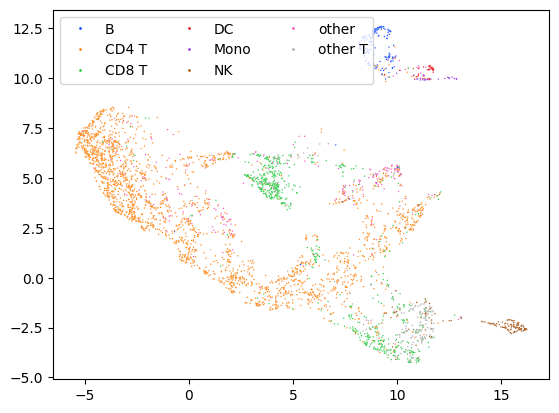

In [8]:
adata_plt = adata[np.random.choice(
        np.arange(adata.shape[0]), 
        adata.shape[0], 
        replace=False
    )].copy()
#adata_plt = adata_plt[~adata_plt.obs.final_ct.isin(["Unknown", "PBMC", "Bone_Marrow"])].copy()
sns.scatterplot(
    x=adata_plt.obsm["umap_MultiVI"][:,0],
    y=adata_plt.obsm["umap_MultiVI"][:,1],
    hue=adata_plt.obs['predicted.celltype.l1'],
    s=1,
    palette='bright',
)
plt.legend(
#     loc='lower left', 
    loc='upper left',
    ncol=3,
    markerscale=2,
#     bbox_to_anchor=(1, 0.5)
)

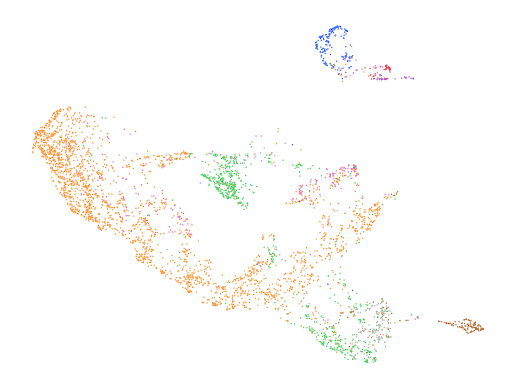

In [11]:
adata_plt = adata[np.random.choice(
        np.arange(adata.shape[0]), 
        adata.shape[0], 
        replace=False
    )].copy()
#adata_plt = adata_plt[~adata_plt.obs.final_ct.isin(["Unknown", "PBMC", "Bone_Marrow"])].copy()
sns.scatterplot(
    x=adata_plt.obsm["umap_MultiVI"][:,0],
    y=adata_plt.obsm["umap_MultiVI"][:,1],
    hue=adata_plt.obs['predicted.celltype.l1'],
    s=1,
    palette='bright',
)
plt.legend().remove()
# 去除坐标轴和边框
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
sns.despine(left=True, bottom=True)  # 移除边框
plt.box(False)  # 进一步防止边框显示

# 展示图
plt.show()

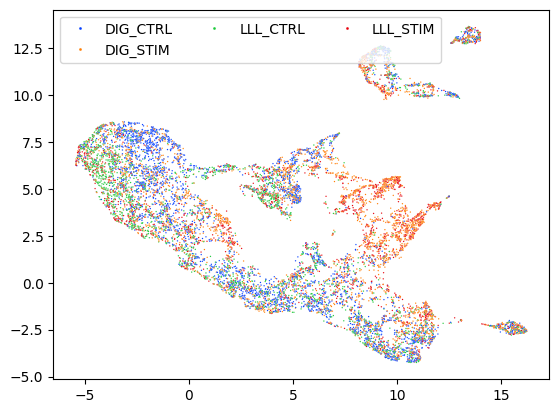

In [10]:
'''adata_plt = adata[np.random.choice(
        np.arange(adata.shape[0]), 
        adata.shape[0], 
        replace=False
    )].copy()'''
#adata_plt = adata_plt[~adata_plt.obs.final_ct.isin(["Unknown", "PBMC", "Bone_Marrow"])].copy()
sns.scatterplot(
    x=adata_plt.obsm["umap_MultiVI"][:,0],
    y=adata_plt.obsm["umap_MultiVI"][:,1],
    hue=adata_plt.obs.sample_type,
    s=1,
    palette='bright',
)
plt.legend(
#     loc='lower left', 
    loc='upper left',
    ncol=3,
    markerscale=2,
#     bbox_to_anchor=(1, 0.5)
)

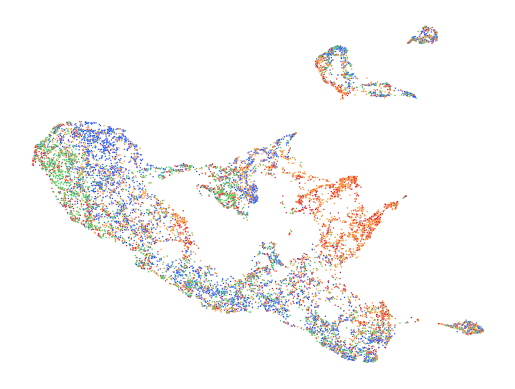

In [12]:
'''adata_plt = adata[np.random.choice(
        np.arange(adata.shape[0]), 
        adata.shape[0], 
        replace=False
    )].copy()'''
#adata_plt = adata_plt[~adata_plt.obs.final_ct.isin(["Unknown", "PBMC", "Bone_Marrow"])].copy()
sns.scatterplot(
    x=adata_plt.obsm["umap_MultiVI"][:,0],
    y=adata_plt.obsm["umap_MultiVI"][:,1],
    hue=adata_plt.obs.sample_type,
    s=1,
    palette='bright',
)
plt.legend().remove()
# 去除坐标轴和边框
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
sns.despine(left=True, bottom=True)  # 移除边框
plt.box(False)  # 进一步防止边框显示

# 展示图
plt.show()

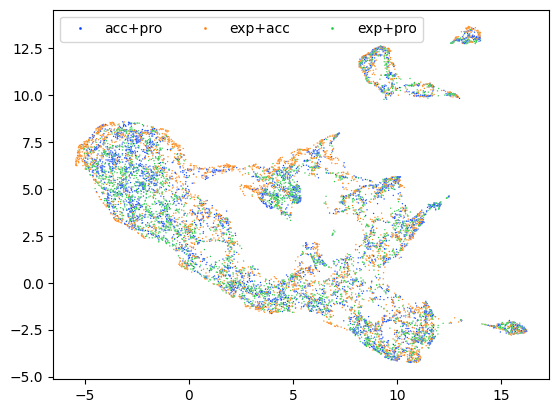

In [13]:
adata_plt = adata[np.random.choice(
        np.arange(adata.shape[0]), 
        adata.shape[0], 
        replace=False
    )].copy()
#adata_plt = adata_plt[~adata_plt.obs.final_ct.isin(["Unknown", "PBMC", "Bone_Marrow"])].copy()
sns.scatterplot(
    x=adata_plt.obsm["umap_MultiVI"][:,0],
    y=adata_plt.obsm["umap_MultiVI"][:,1],
    hue=adata_plt.obs.modality,
    s=1,
    palette='bright',
)
plt.legend(
#     loc='lower left', 
    loc='upper left',
    ncol=3,
    markerscale=2,
#     bbox_to_anchor=(1, 0.5)
)

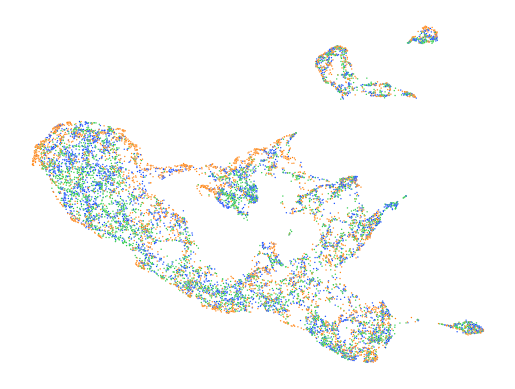

In [14]:
adata_plt = adata[np.random.choice(
        np.arange(adata.shape[0]), 
        adata.shape[0], 
        replace=False
    )].copy()
#adata_plt = adata_plt[~adata_plt.obs.final_ct.isin(["Unknown", "PBMC", "Bone_Marrow"])].copy()
sns.scatterplot(
    x=adata_plt.obsm["umap_MultiVI"][:,0],
    y=adata_plt.obsm["umap_MultiVI"][:,1],
    hue=adata_plt.obs.modality,
    s=1,
    palette='bright',
)
plt.legend().remove()

# 去除坐标轴和边框
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
sns.despine(left=True, bottom=True)  # 移除边框
plt.box(False)  # 进一步防止边框显示

# 展示图
plt.show()

In [15]:
def compute_batch_mixing(latent, batch_id, k):
    nng = kneighbors_graph(latent, n_neighbors=k).tocoo()
    batch_id = pd.Categorical(batch_id).codes
    self_id = batch_id[nng.row]
    ne_id = batch_id[nng.col]
    
    _, c = np.unique(batch_id, return_counts=True)
    theoretic_score = ((c / c.sum()) ** 2).sum()
    return (self_id == ne_id).mean() / theoretic_score

def compute_foscttm(latent_acc, latent_exp):
    """
    计算 FOSCTTM 分数
    
    返回: 平均 FOSCTTM 值
    """
    distances = cdist(latent_acc, latent_exp, metric='euclidean')  # 计算所有细胞的欧式距离
    foscttm_values = []
    num_cells=latent_exp.shape[0]

    for i in range(num_cells):  # 遍历所有已知匹配的细胞对
        d_true = distances[i, i]  # 真实匹配的距离
        d_others = distances[i, :]  # 该细胞到所有其他细胞的距离
        
        rank = np.sum(d_others < d_true) / num_cells  # 计算 FOSCTTM
        foscttm_values.append(rank)

    return np.mean(foscttm_values)  # 返回平均 FOSCTTM 值

In [16]:
latent = adata.obsm["X_multiVI"]
enrichments = []
for K in [15,50,150,500]:
    print(K)
    enrichments.append(
            (K, 
            compute_batch_mixing(latent, adata.obs.modality, K))
        )
asw_modality = silhouette_score(latent, adata.obs["modality"], metric='euclidean')
print(f"ASW for modality: {asw_modality:.4f}")
print(enrichments)

15
50
150
500
ASW for modality: -0.0163
[(15, 1.4587740086872432), (50, 1.327796368361502), (150, 1.2136836729427183), (500, 1.1068784603054085)]


In [17]:
latent = adata.obsm["X_multiVI"]
enrichments = []
for K in [15,50,150,500]:
    print(K)
    enrichments.append(
            (K, 
            compute_batch_mixing(latent, adata.obs.sample_type, K))
        )
asw_batch = silhouette_score(latent, adata.obs["sample_type"], metric='euclidean')
print(f"ASW for batch: {asw_batch:.4f}")
print(enrichments)

15
50
150
500
ASW for batch: -0.0435
[(15, 1.6065778155302937), (50, 1.5265969601851053), (150, 1.4355042062349164), (500, 1.31071173874669)]


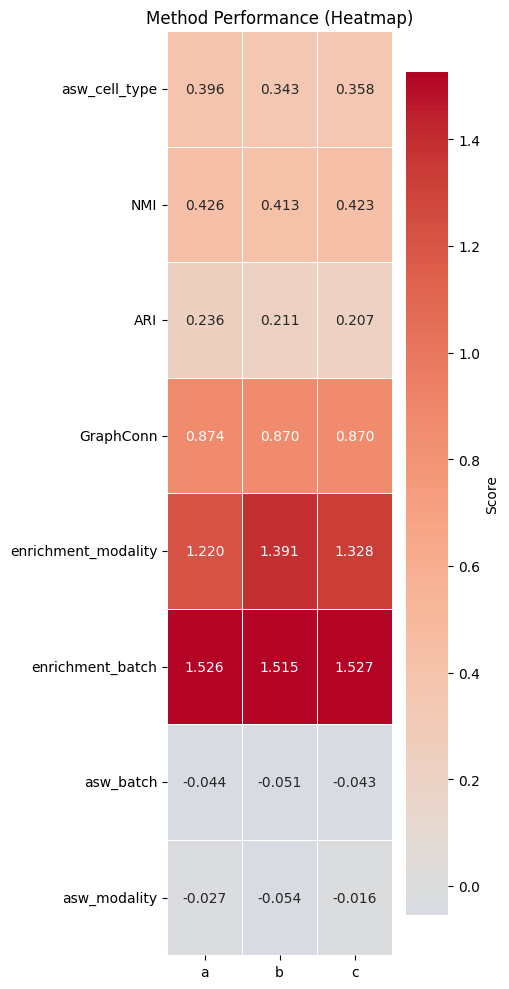

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# 模拟你的数据
data = pd.DataFrame({
    'asw_cell_type': [0.3956, 0.3425, 0.3578,],
    'NMI': [0.4256, 0.4135, 0.4231],
    'ARI': [0.2364, 0.2110, 0.2071],
    'GraphConn': [0.8738, 0.8699, 0.8702],
    'enrichment_modality': [1.220, 1.3905 ,1.3278],
    'enrichment_batch': [1.526,1.5150 ,1.5266],
    'asw_batch': [-0.0436, -0.0508 ,-0.0435],
    'asw_modality': [-0.0271,  -0.0545 ,-0.0163],
}, index=['a', 'b', 'c'])
#index=['', 'ALLcomb', '2ineach']
# 准备画图数据
scores = data.iloc[0]
metrics = scores.index
values = scores.values

# 绘图
plt.figure(figsize=(5,10))  # 横向展示
sns.heatmap(data.T, annot=True, cmap='coolwarm', center=0, fmt=".3f",
            cbar_kws={'label': 'Score'}, linewidths=0.5)

plt.title("Method Performance (Heatmap)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
